<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# openEO Platform - Analysis Ready Data

## Sample processing pipelines for Radar ARD

In [1]:
import openeo
from eo_utils import *

Please make sure to have the latest openeo library installed, this notebook requires openeo >= 0.9.0 :
 ```
pip install openeo --upgrade
 ```


In [2]:
openeo.__version__

'0.9.0'

**1. Open the connection with openEO Platform. You can autenticate using EGI.**

Please refer to the openEO Platform official documentation for details about the installation and authentication: https://docs.openeo.cloud/getting-started/python/

In [3]:
backend = "openeo.cloud"
conn = openeo.connect(backend).authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


**2. Area of Interest selection**

Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [4]:
center = [46.49, 11.35]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.49, 11.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Get the bounding box from the previous map.

In [5]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 11.293602 
east 11.382866 
south 46.460163 
north 46.514768


<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## Radar - Sentinel-1: ARD SAR Backscatter

### On-demand SAR Backscatter

The **ard_normalized_radar_backscatter** process computes **on-demand** backscatter from SAR input.

The radiometric correction coefficient is gamma0 (terrain).

More details here: https://docs.openeo.cloud/processes/#ard_normalized_radar_backscatter

**3. Specify area of interest, temporal extent, pola**

In [6]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-01", "2021-01-08"]
bands           = ["VV","VH"]

properties = {"orbitDirection": lambda od: eq(od, "ASCENDING")} ## Orbit direction filtering

s1 = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent,properties=properties)

**4. Apply the ARD SAR processing and conversion from linear to dB scale.**

In [7]:
s1bs_linear = s1.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")
s1bs = s1bs_linear.apply(lambda x: 10 * x.log(base=10))

**4.1 If our area of interest is small, a direct request is possible, but this will not return the json metadata.**

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [8]:
%time s1bs.download("./data/sar_bs.nc",format="NetCDF")

CPU times: user 56 ms, sys: 76 ms, total: 132 ms
Wall time: 1min 10s


**5. Save process as final step, here we use NetCDF as output format.**

In [9]:
s1bs_netcdf = s1bs.save_result(format="NetCDF")

**6. Now we will create a batch job and start it. More info about batch jobs can be found here:**

https://docs.openeo.cloud/getting-started/python/#batch-job-execution

https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [10]:
job_bs = s1bs_netcdf.send_job(title="SAR_backscatter")
job_id_bs = job_bs.job_id
if job_id_bs:
    print("Batch job created with id: ",job_id_bs)
    job_bs.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  vito-c0ce7466-0a54-4a2f-9852-1ba809218690


Get a description of the job and check its status.

In [19]:
job_bs = conn.job(job_id_bs)
job_description = job_bs.describe_job()
print("Batch job with id: ",job_id_bs, ' is ',job_description['status'])

Batch job with id:  vito-c0ce7466-0a54-4a2f-9852-1ba809218690  is  finished


Once the status is 'finished', it is possible to inspect the results. Download links are provided to retrieve data and metadata.

In [20]:
results = job_bs.get_results()
results

<JobResults for job 'vito-c0ce7466-0a54-4a2f-9852-1ba809218690'>

**Optional: download complete result with metadata and source files**

Results contain STAC metadata and the processed data. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

**7. Output visualization**

In [13]:
S1_ard = xr.open_dataset("./data/sar_bs.nc")
S1_ard

<xarray.Dataset>
Dimensions:                (t: 1, x: 768, y: 1024)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-03
  * x                      (x) float64 6.758e+05 6.759e+05 ... 6.835e+05
  * y                      (y) float64 5.156e+06 5.156e+06 ... 5.146e+06
Data variables:
    crs                    |S1 ...
    VV                     (t, y, x) float32 ...
    VH                     (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

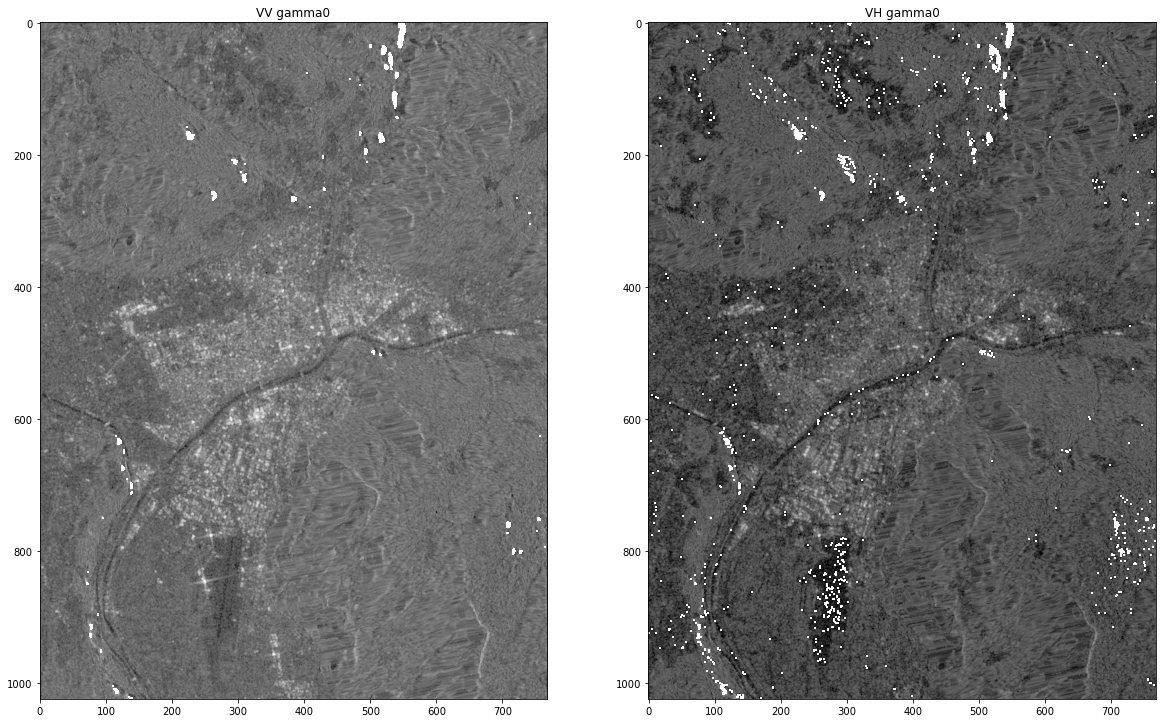

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(S1_ard.VV[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0')
ax2.imshow(S1_ard.VH[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0')
plt.show()

### Additional SAR processing capabilities:


The **sar_backscatter** process offer multiple parameters that can be used depending on the application needs: https://docs.openeo.cloud/processes/#sar_backscatter

We can choose among the following coefficients:
- **beta0**:            radar brightness
- **sigma0-ellipsoid**: ground area computed with ellipsoid earth model
- **sigma0-terrain**:   ground area computed with terrain earth model
- **gamma0-ellipsoid**: ground area computed with ellipsoid earth model in sensor line of sight
- **gamma0-terrain**:   ground area computed with terrain earth model in sensor line of sight (default)
- **null**:             non-normalized backscatter
